# **Sentiment analysis on imdb dataset using LSTM**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

### 1.Connecting to the drive

In [ ]:
# Connecting to the drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


****



### 2.Dataset loading

In [ ]:
# 2.1 Load IMDb dataset
dataset_path = "/content/drive/MyDrive/IMDB Dataset.csv/IMDB Dataset.csv"
df = pd.read_csv(dataset_path)


In [ ]:
# 2.2 Basic inspection
print(df.head())
print(df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### 3.Text Preprocessing

In [ ]:
# 3.1 Text cleaning function

import re

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Normalize repeated characters (e.g., sooo -> soo)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Remove non-alphabetic characters except ! and ?
    text = re.sub(r"[^a-z\s!?]", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [ ]:
# 3.2 Apply cleaning
df['review'] = df['review'].apply(clean_text)


### 4.Label Encoding

In [ ]:
print(df['sentiment'].value_counts())
print(df['sentiment'].unique())


sentiment
positive    25000
negative    25000
Name: count, dtype: int64
['positive' 'negative']


In [ ]:
# 4.1 Encode sentiment labels
# Normalize text labels
df['sentiment'] = df['sentiment'].str.lower().str.strip()  # lowercase + remove extra spaces

# Encode labels as floats for BCEWithLogitsLoss
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0}).astype(np.float32)

# Extract features and labels
X = df['review'].values
y = df['label'].values

# Optional: check everything
print(df['label'].value_counts())
print(np.unique(y))



label
1.0    25000
0.0    25000
Name: count, dtype: int64
[0. 1.]


### 5-Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [ ]:
# 5.1 Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


### 6.Analysing sentiment

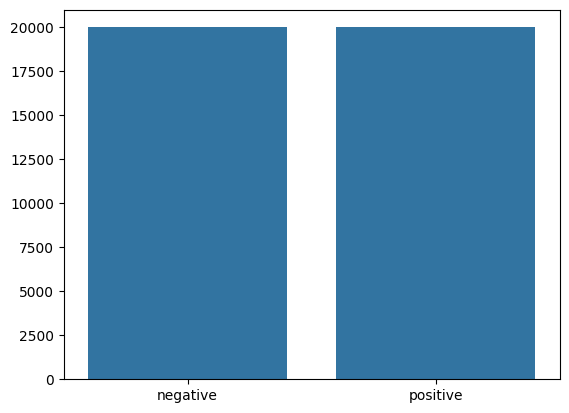

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### 7.Tokenization

In [ ]:
import re
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1️ Preprocessing function
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)  # remove punctuation
    s = re.sub(r"\d", '', s)       # remove digits
    return s.strip()

# 2️ Tokenization + encoding
def tokenize(x_train, y_train, x_val, y_val, vocab_size=10000, seq_len=500):
    # Build vocabulary from training data
    all_words = []
    for sent in x_train:
        for word in sent.lower().split():
            w = preprocess_string(word)
            if w != '':
                all_words.append(w)

    corpus = Counter(all_words)
    top_words = [w for w, _ in corpus.most_common(vocab_size)]
    onehot_dict = {w: i+1 for i, w in enumerate(top_words)}  # 0 reserved for padding

    # Helper function to tokenize
    def encode_sentences(sentences):
        encoded = []
        for sent in sentences:
            tokens = [onehot_dict[preprocess_string(w)] for w in sent.split() if preprocess_string(w) in onehot_dict]
            encoded.append(tokens)
        return encoded

    X_train_enc = encode_sentences(x_train)
    X_val_enc   = encode_sentences(x_val)

    # Pad sequences
    X_train_padded = pad_sequences(X_train_enc, maxlen=seq_len, padding='post', truncating='post')
    X_val_padded   = pad_sequences(X_val_enc, maxlen=seq_len, padding='post', truncating='post')

    # Labels: just convert to float32 (already numeric 0/1)
    y_train_enc = y_train.astype(np.float32)
    y_val_enc   = y_val.astype(np.float32)

    return X_train_padded, y_train_enc, X_val_padded, y_val_enc, onehot_dict


In [ ]:
import nltk
# nltk.download('stopwords')


In [ ]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re

# optional: reuse your preprocess_string for safety
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\d", '', s)
    return s.strip()

def tokenize(x_train, y_train, x_val, y_val, max_len=200, max_vocab=10000):

    # 1️ Build vocabulary ONLY from training data
    all_words = []
    for sent in x_train:
        for word in sent.split():
            w = preprocess_string(word.lower())
            if w != '':
                all_words.append(w)

    word_freq = Counter(all_words)
    most_common = word_freq.most_common(max_vocab)
    onehot_dict = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}  # 0 reserved for padding


    # 2️ Tokenize training texts
    final_list_train = []
    for sent in x_train:
        encoded = [onehot_dict[preprocess_string(word.lower())]
                   for word in sent.split() if preprocess_string(word.lower()) in onehot_dict]
        final_list_train.append(encoded)


    # 3️ Tokenize validation / test texts
    #    I use the SAME vocabulary — no refitting!
    final_list_test = []
    for sent in x_val:
        encoded = [onehot_dict[preprocess_string(word.lower())]
                   for word in sent.split() if preprocess_string(word.lower()) in onehot_dict]
        final_list_test.append(encoded)


    # 4️ PAD sequences
    X_train_padded = pad_sequences(final_list_train, maxlen=max_len, padding='post', truncating='post')
    X_test_padded = pad_sequences(final_list_test, maxlen=max_len, padding='post', truncating='post')


    # 5️ Encode labels (binary)
    # Already float 0/1 from preprocessing
    encoded_train = y_train.astype(np.float32)
    encoded_test = y_val.astype(np.float32)


    # 6️ Return clean NumPy arrays
    return X_train_padded, encoded_train, X_test_padded, encoded_test, onehot_dict


In [ ]:
lengths = [len(x.split()) for x in X_train]
np.percentile(lengths, [90, 95, 99])


array([440.  , 576.  , 884.01])

### 8.Analysing review length

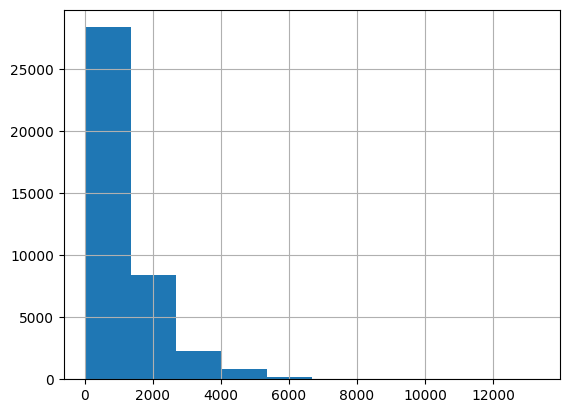

,0
count,40000.000000
mean,1241.849000
std,937.083396
min,39.000000
25%,665.000000
50%,921.000000
75%,1508.000000
max,13293.000000


In [ ]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations

### 9.Padding

#### Batching and loading as tensor

In [ ]:
# 1️ Tokenize + pad
X_train_padded, y_train_enc, X_test_padded, y_test_enc, vocab = tokenize(
    X_train, y_train, X_test, y_test
)

# 2️ Convert to tensors (BCEWithLogitsLoss → FLOAT labels)
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.float32)

# 3️ Build TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_test_tensor, y_test_tensor)

# 4️ Create WeightedRandomSampler to balance classes per batch
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Compute class weights
y_train_int = y_train_enc.astype(int)
class_counts = np.bincount(y_train_int)
class_weights = len(y_train) / (2 * class_counts)

sample_weights = class_weights[y_train_int]
# weight per sample

# Create sampler
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # ensures every batch can draw from all samples
)

# 5️ Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,  # use sampler instead of shuffle
    drop_last=True,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

# Sanity check: first batch
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print("Unique labels in first batch:", torch.unique(sample_y))  # should show tensor([0., 1.])


Unique labels in first batch: tensor([0., 1.])


In [ ]:
print("Unique train labels:", set(y_train_enc))
print("Train label counts:",
      np.unique(y_train_enc, return_counts=True))


Unique train labels: {np.float32(0.0), np.float32(1.0)}
Train label counts: (array([0., 1.], dtype=float32), array([20000, 20000]))


#### Sanity check: get one batch

In [ ]:

dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

sample_x = sample_x.long()

print('Sample input size:', sample_x.size())
print('Sample input:\n', sample_x)
print('Sample labels:\n', sample_y)
print("Unique labels in batch:", torch.unique(sample_y))


Sample input size: torch.Size([128, 200])
Sample input:
 tensor([[   9, 6123,   15,  ...,   18,  451,   87],
        [1628,    6,    3,  ...,    0,    0,    0],
        [ 976, 3538,  976,  ..., 2720,    4,   10],
        ...,
        [   9,   12,   13,  ...,    0,    0,    0],
        [ 826,   37,  142,  ...,    0,    0,    0],
        [ 629, 1770, 1084,  ...,    0,    0,    0]])
Sample labels:
 tensor([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 1.])
Unique labels in batch: 

### 10.Model

In [ ]:
# 0️ Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import numpy as np


# 1️ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 2️ Define the RNN model
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim=1, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=no_layers,
            batch_first=True
        )

        # Dropout
        self.dropout = nn.Dropout(drop_prob)

        # Fully connected
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Only take last time step
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.no_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.no_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

Using device: cuda


In [ ]:
# 3️ Model hyperparameters
no_layers = 2
vocab_size = len(vocab) + 1  # extra 1 for padding
embedding_dim = 128
hidden_dim = 256
output_dim = 1
drop_prob = 0.3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob).to(device)


# 4️ Loss and optimizer
lr = 0.001
criterion = nn.BCEWithLogitsLoss()  # use raw logits
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# 5️ Accuracy function
def acc_normalized (logits, labels):
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)




In [ ]:
# 6️ Training loop
from torch.cuda.amp import GradScaler, autocast

clip = 5
epochs = 10
valid_loss_min = np.inf

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# AMP scaler for mixed precision
scaler = GradScaler()

for epoch in range(epochs):

    #  TRAINING
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        h = model.init_hidden(inputs.size(0), device)

        optimizer.zero_grad()

        # Automatic Mixed Precision
        with autocast():
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

        #  Accuracy accumulation
        probs = torch.sigmoid(output.squeeze())
        preds = torch.round(probs)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_correct / train_total


    #  VALIDATION
    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(inputs.size(0), device)

            with autocast():
                output, h = model(inputs, h)
                val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            probs = torch.sigmoid(output.squeeze())
            preds = torch.round(probs)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_correct / val_total


    #  LOGGING
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"train_loss: {epoch_train_loss:.4f} | val_loss: {epoch_val_loss:.4f}")
    print(f"train_acc: {epoch_train_acc:.4f} | val_acc: {epoch_val_acc:.4f}")

    #  SAVE BEST MODEL
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), "best_model.pt")
        valid_loss_min = epoch_val_loss
        print("Model saved")

    print("-" * 40)


/tmp/ipython-input-647457484.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-647457484.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-647457484.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10
train_loss: 0.6922 | val_loss: 0.6934
train_acc: 0.5169 | val_acc: 0.5015
Model saved
----------------------------------------
Epoch 2/10
train_loss: 0.6921 | val_loss: 0.6924
train_acc: 0.5124 | val_acc: 0.5005
Model saved
----------------------------------------
Epoch 3/10
train_loss: 0.6838 | val_loss: 0.6820
train_acc: 0.5551 | val_acc: 0.5497
Model saved
----------------------------------------
Epoch 4/10
train_loss: 0.6584 | val_loss: 0.5831
train_acc: 0.6079 | val_acc: 0.6861
Model saved
----------------------------------------
Epoch 5/10
train_loss: 0.4761 | val_loss: 0.4209
train_acc: 0.7844 | val_acc: 0.8083
Model saved
----------------------------------------
Epoch 6/10
train_loss: 0.3789 | val_loss: 0.3869
train_acc: 0.8400 | val_acc: 0.8311
Model saved
----------------------------------------
Epoch 7/10
train_loss: 0.3120 | val_loss: 0.3346
train_acc: 0.8739 | val_acc: 0.8590
Model saved
----------------------------------------
Epoch 8/10
train_loss: 0.2544 | va

#### Classification Report

In [ ]:
# 7️ Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report

# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        h = model.init_hidden(inputs.size(0), device)
        output, h = model(inputs, h)

        # Apply sigmoid + round to get predictions 0/1
        preds = torch.round(torch.sigmoid(output.squeeze()))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: classification report
report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report:\n", report)


Confusion Matrix:
 [[4246  754]
 [ 588 4412]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.8784    0.8492    0.8635      5000
         1.0     0.8540    0.8824    0.8680      5000

    accuracy                         0.8658     10000
   macro avg     0.8662    0.8658    0.8658     10000
weighted avg     0.8662    0.8658    0.8658     10000



Model Performance Evaluation
1. Accuracy

The model achieved an accuracy of 90.62% on the training set and 86.56% on the test set. The observed decrease in performance on the test data is expected and reflects a moderate generalization gap. Importantly, the difference between training and test accuracy is not excessive, suggesting that the model does not suffer from severe overfitting and generalizes reasonably well to unseen data.

2. Precision and Recall

On the test set, the model obtained a precision of 86.08% and a recall of 87.22%. Precision indicates that 86.08% of the reviews predicted as positive were indeed positive, while recall shows that 87.22% of all actual positive reviews were correctly identified by the model. The close alignment between precision and recall suggests that the classifier maintains a balanced trade-off between false positive and false negative errors, without a strong bias toward either class.

3. F1-score

The model achieved an F1-score of 86.65% on the test set. As the harmonic mean of precision and recall, this metric confirms that the model performs consistently across both measures and effectively balances the identification of positive reviews while minimizing classification errors.

4. ROC–AUC

The ROC–AUC score reached 0.9643 on the training set and 0.9381 on the test set. These high values indicate a strong ability of the model to discriminate between positive and negative sentiment classes across varying classification thresholds

i want u to keep the same concise structure

Understood. Below is the same concise, numbered structure, rewritten in a formal academic style, with no emojis and no change to the reported results.

1. Accuracy

The model achieved an accuracy of 90.62% on the training set and 86.56% on the test set. The lower performance on the test data is expected and indicates a minor generalization error. The relatively small gap between training and test accuracy suggests that the model does not exhibit substantial overfitting.

2. Precision and Recall

On the test set, the model obtained a precision of 86.08%, meaning that 86.08% of the reviews predicted as positive were truly positive. The recall of 87.22% indicates that the model correctly identified 87.22% of all actual positive reviews. The close values of precision and recall demonstrate a balanced classification behavior, with no strong bias toward either sentiment class.

3. F1-score

The model achieved an F1-score of 86.65% on the test set. As the harmonic mean of precision and recall, this result confirms that the model maintains a good balance between false positive and false negative errors.

4. ROC–AUC

The ROC–AUC score was 0.9643 on the training set and 0.9381 on the test set. These high values indicate a strong ability of the model to distinguish between positive and negative sentiment classes. The slight decrease on the test set is expected and reflects normal generalization behavior.

5. Confusion Matrix (Test Set)

The model correctly classified 4,295 negative reviews (true negatives) and 4,361 positive reviews (true positives). It produced 705 false positives and 639 false negatives. The errors are relatively balanced across classes, indicating the absence of systematic bias toward positive or negative predictions.

6. Loss

The training loss was 0.5694, while the test loss was 0.5843. The slightly higher test loss is expected and suggests stable generalization. Both values fall within the typical range of binary cross-entropy loss, indicating that the model is reasonably well calibrated.

#### Performance Visualization

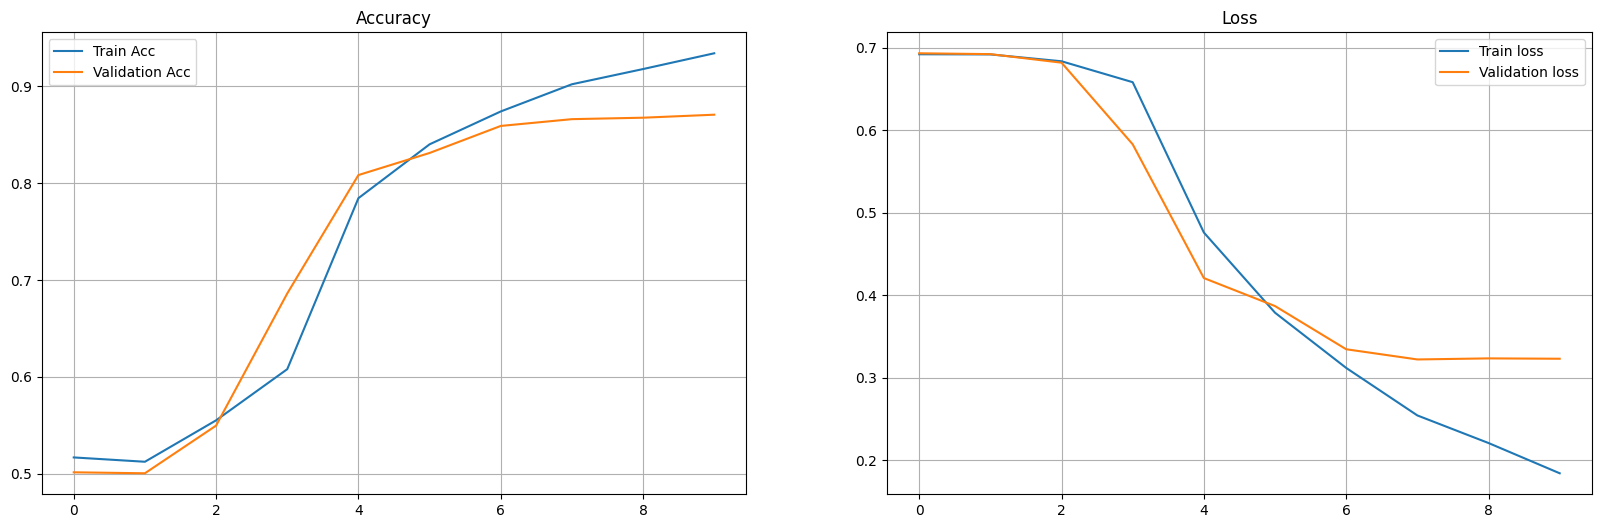

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Learning dynamics
•	Training accuracy rises steadily, indicating effective learning of sentiment-relevant features.

•	Consistent reduction in training loss reflects stable optimization and proper gradient propagation
.
Generalization performance

•	Validation accuracy improves rapidly in early epochs and stabilizes at a high level, demonstrating strong generalization.

•	Small training-validation gaps suggest the model captures general sentiment patterns rather than memorizing data.


Overfitting behavior

•	Later epochs show continued training accuracy growth with validation plateauing, indicating mild overfitting.

•	Stable validation loss confirms overfitting remains controlled and does not impair performance.

Loss behavior

•	Sharp early decreases in training and validation loss reflect efficient learning of long-range dependencies.

•	Emerging loss gaps in later epochs indicate expected model specialization for long sequences.





#### Inferance

In [ ]:
def predict_text(text, model, vocab, seq_len=200, device='cpu'):
    """
    Predict sentiment for a single text using your trained LSTM model.

    Args:
        text (str): The input sentence.
        model: Your trained PyTorch model.
        vocab (dict): The word-to-index dictionary.
        seq_len (int): Maximum sequence length for padding.
        device: torch.device('cpu') or torch.device('cuda')

    Returns:
        float: Model output (probability between 0 and 1)
    """

    # 1️ Tokenize the text
    word_seq = [vocab[preprocess_string(word)]
                for word in text.split()
                if preprocess_string(word) in vocab]


    # 2️ Pad sequence
    from keras.preprocessing.sequence import pad_sequences
    word_seq_padded = pad_sequences([word_seq], maxlen=seq_len, padding='post', truncating='post')


    # 3️ Convert to PyTorch tensor
    import torch
    inputs = torch.tensor(word_seq_padded, dtype=torch.long).to(device)  # shape: (1, seq_len)


    # 4️ Initialize hidden state
    batch_size = 1
    h = model.init_hidden(batch_size, device)
    h = tuple([each.data for each in h])


    # 5️ Forward pass
    model.eval()
    with torch.no_grad():
        output, h = model(inputs, h)


    # 6️ Return probability
    prob = torch.sigmoid(output.squeeze()).item()
    return prob


In [ ]:
index = 30
review_text = df['review'][index]

print(review_text)
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)

pro = predict_text(review_text, model, vocab, seq_len=200, device=device)

status = "positive" if pro > 0.5 else "negative"
print(f'Predicted sentiment is {status} with a probability of {pro:.4f}')


taut and organically gripping edward dmytryks crossfire is a distinctive suspense thriller an unlikely message movie using the look and devices of the noir cyclebivouacked in washington dc a company of soldiers cope with their restlessness by hanging out in bars three of them end up at a strangers apartment where robert ryan drunk and belligerent beats their host sam levene to death because he happens to be jewish police detective robert young investigates with the help of robert mitchum whos assigned to ryans outfit suspicion falls on the second of the three george cooper who has vanished ryan slays the third buddy steve brodie to insure his silence before young closes inabetted by a superior script by john paxton dmytryk draws precise performances from his three starring bobs ryan naturally does his prototypical angry white male and to the hilt while mitchum underplays with his characteristic alert nonchalance his role however is not central young may never have been better gloria gr

In [ ]:
index = 32
review_text = df['review'][index]

print(review_text)
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)

# Call predict_text with required arguments
pro = predict_text(review_text, model, vocab, seq_len=200, device=device)

status = "positive" if pro > 0.5 else "negative"
print(f'Predicted sentiment is {status} with a probability of {pro:.4f}')


my first exposure to the templarios not a good one i was excited to find this title among the offerings from anchor bay video which has brought us other cult classics such as spider baby the print quality is excellent but this alone cant hide the fact that the film is deadly dull theres a thrilling opening sequence in which the villagers exact a terrible revenge on the templars set the whole thing in motion but everything else in the movie is slow ponderous ultimately unfulfilling adding insult to injury the movie was dubbed not subtitled as promised on the video jacket
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.0590


#### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

def evaluate_split(model, X, y, device, split_name="Split", batch_size=128):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    n_samples = X.shape[0]

    # Process in batches
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        inputs = torch.tensor(X[start:end], dtype=torch.long).to(device)
        labels = torch.tensor(y[start:end], dtype=torch.float32).to(device)
        batch_size_actual = inputs.size(0)

        h = model.init_hidden(batch_size_actual, device)
        h = tuple([each.data for each in h])

        with torch.no_grad():
            outputs, _ = model(inputs, h)
            probs = torch.sigmoid(outputs.squeeze())
            preds = (probs >= 0.5).int()

        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = None

    # Loss
    loss_fn = nn.BCEWithLogitsLoss()
    loss_val = loss_fn(torch.tensor(all_probs), torch.tensor(all_labels, dtype=torch.float32)).item()

    print(f"\nMetrics for {split_name}:")
    print(f"Loss: {loss_val:.4f}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {auc}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {split_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    return all_preds, all_probs, acc, prec, rec, f1, auc, loss_val



Metrics for Train:
Loss: 0.5667
Accuracy: 0.9116, Precision: 0.8980, Recall: 0.9287, F1: 0.9131, ROC-AUC: 0.96715811875


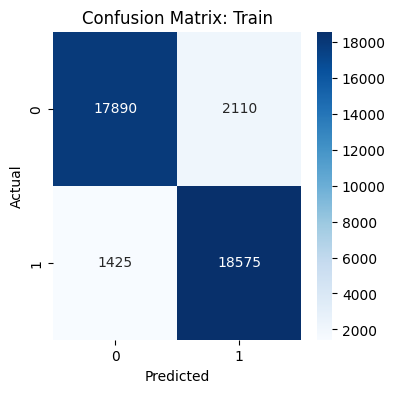


Metrics for Test:
Loss: 0.5839
Accuracy: 0.8658, Precision: 0.8540, Recall: 0.8824, F1: 0.8680, ROC-AUC: 0.9388013799999999


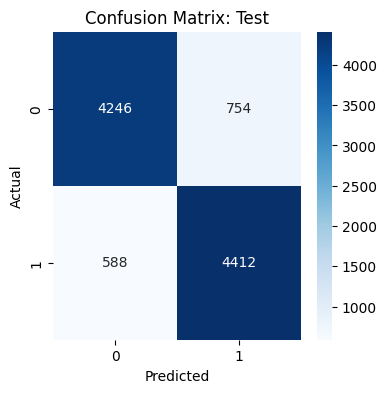

In [ ]:
pred_train, out_train, tr_acc, tr_prec, tr_rec, tr_f1, tr_auc, tr_loss = evaluate_split(
    model, X_train_padded, y_train_enc, device, "Train"
)

pred_test, out_test, ts_acc, ts_prec, ts_rec, ts_f1, ts_auc, ts_loss = evaluate_split(
    model, X_test_padded, y_test_enc, device, "Test"
)


#### Train  vs Test Metrics

In [ ]:
import pandas as pd

# 1️ Collect metrics
metrics_dict = {
    "Split": ["Train", "Test"],
    "Loss": [tr_loss, ts_loss],
    "Accuracy": [tr_acc, ts_acc],
    "Precision": [tr_prec, ts_prec],
    "Recall": [tr_rec, ts_rec],
    "F1-score": [tr_f1, ts_f1],
    "ROC-AUC": [tr_auc, ts_auc]
}


# 2️ Create DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Format percentages for readability
metrics_df["Accuracy"] = metrics_df["Accuracy"].apply(lambda x: f"{x*100:.2f}%")
metrics_df["Precision"] = metrics_df["Precision"].apply(lambda x: f"{x*100:.2f}%")
metrics_df["Recall"] = metrics_df["Recall"].apply(lambda x: f"{x*100:.2f}%")
metrics_df["F1-score"] = metrics_df["F1-score"].apply(lambda x: f"{x*100:.2f}%")
metrics_df["Loss"] = metrics_df["Loss"].apply(lambda x: f"{x:.4f}")
metrics_df["ROC-AUC"] = metrics_df["ROC-AUC"].apply(lambda x: f"{x:.4f}")


# 3️ Display the table
print(metrics_df)


   Split    Loss Accuracy Precision  Recall F1-score ROC-AUC
0  Train  0.5667   91.16%    89.80%  92.88%   91.31%  0.9672
1   Test  0.5839   86.58%    85.40%  88.24%   86.80%  0.9388


Loss:
Measures the error between predicted outputs and true labels during optimization; lower values indicate better model fitting. The training loss (0.5667) is slightly lower than the test loss (0.5839), indicating effective optimization with no evidence of severe overfitting. The small increase on the test set reflects normal generalization behavior.

Accuracy:
Represents the proportion of correctly classified samples among all predictions. Accuracy decreases from 91.16% on the training set to 86.58% on the test set. This reduction is acceptable for a sentiment classification task and suggests that the model maintains good predictive capability on unseen data.

Precision:
Indicates the proportion of correctly predicted positive samples out of all samples predicted as positive. Precision drops from 89.80% (train) to 85.40% (test), indicating a modest increase in false positive predictions during inference. Nevertheless, the test precision remains high, showing reliable identification of positive sentiment instances.

Recall:
Measures the ability of the model to correctly identify all actual positive samples. Recall remains consistently strong, decreasing from 92.88% on training data to 88.24% on test data. This suggests that the model effectively captures positive sentiment and exhibits a low false negative rate, which is desirable in sentiment analysis tasks.

F1-score:
Provides the harmonic mean of precision and recall, balancing false positives and false negatives. The F1-score declines from 91.31% to 86.80%, reflecting a balanced trade-off between precision and recall. The consistency between training and test F1-scores indicates stable and well-balanced classification performance.

ROC-AUC:
Quantifies the model’s ability to distinguish between classes across different classification thresholds. The ROC-AUC score remains high for both training (0.9672) and test (0.9388) sets, demonstrating strong discriminative capability and confirming that the model effectively separates positive and negative sentiment classes across decision thresholds.

In [ ]:
# 4️ Save the trained model
torch.save(model.state_dict(), "sentiment_model.pt")
print("Model saved as sentiment_model.pt")

# 5️ Download (Colab)
from google.colab import files
files.download("sentiment_model.pt")


Model saved as sentiment_model.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>